# 自宅環境でのTensorflowの実行テスト

In [1]:
import pandas as pd
import numpy as np
import re # 正規表現のためのモジュール
import seaborn as sns
import matplotlib.pyplot as plt

## Load data and preprocessing
データを読み込んで前処理(欠損値除去,特徴探索)を行う. ここではニューラルネットワークを使用することが主であるから詳細は省略する.

In [2]:
# load data
train = pd.read_csv("./TitanicData/train.csv")
test = pd.read_csv("./TitanicData/test.csv")
gender_submission = pd.read_csv("./TitanicData/gender_submission.csv")

# Store PassengerID
PassengerID = test["PassengerId"]

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# merge train and test
full_data = [train,test]

# 特徴量の追加
# 名前の長さを保持する"Name_length"を生成
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Cabinが欠損値かどうかを0,1で保持する"Has_Cabin"を生成 
# Dataframe.apply() : 各要素ごとに処理
# lambda 引数 : 式
# 各要素の型がfloat(NaN)のとき0,それ以外のとき1を"Has_Cabin"に格納
train["Has_Cabin"] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test["Has_Cabin"] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# 特徴量エンジニアリング
for dataset in full_data: # trainとtestのそれぞれについて
    # 搭乗していた家族の人数の特徴量を生成
    # 搭乗していた家族の人数 = 兄弟,配偶者の人数 + 親,子供の人数 + 1(自分)
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1

for dataset in full_data:
    # 1人で搭乗したいたかどうかの特徴量を生成
    dataset["IsAlone"] = 0
    # "Familysize"が1のレコードの"IsAlone"を1に上書き
    dataset.loc[dataset["FamilySize"]==1,"IsAlone"] = 1

for dataset in full_data:
    # "Embarked"の欠損値を"S"で埋める
    dataset["Embarked"] = dataset["Embarked"].fillna("S")
    # "Fare"の欠損値を訓練セットの中央値で埋める
    dataset["Fare"] = dataset["Fare"].fillna(train["Fare"].median())
# Fareを訓練セットの四分位数で離散化した"CategoricalFare"特徴量を生成
train["CategoricalFare"] = pd.qcut(train["Fare"],4)

for dataset in full_data:
    age_avg = dataset["Age"].mean() # Ageの平均
    age_std = dataset["Age"].std() # Ageの標準偏差
    age_null_count = dataset["Age"].isnull().sum() # AgeがNanのレコード数をカウント
    age_null_random_list = np.random.randint(age_avg-age_std,age_avg+age_std,size=age_null_count) # age_avgを中心として2*age_stdの範囲で乱数を生成
    dataset["Age"][np.isnan(dataset["Age"])] = age_null_random_list # AgeがNanのレコードに生成した乱数を代入
    dataset["Age"] = dataset["Age"].astype(int) # Ageをint型に変換
train["CategoricalAge"] = pd.cut(train["Age"],5) # Ageを分位数5で離散化した"CategoricalAge"特徴量を生成

def get_title(name):
    """名前から敬称を抽出する関数
    Args:
    name(str) : 敬称を抽出する文字列
    
    Returns:
    敬称 : 敬称が文字列に含まれるとき
    "" : 敬称が文字列に含まれないとき
    """
    # 正規表現
    # () : 文字を一つのグループにまとめる
    # A-Za-z : 1桁の全角英字(大文字)と1桁の全角英字(大文字)
    # + 直前の文字が1回以上繰り返すときにマッチする
    # \. .(ドット)
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    # "Name"の各要素をget_title関数に渡して,結果を"Title"に格納する.
    dataset["Title"] = dataset["Name"].apply(get_title)

for dataset in full_data:
    # 稀な敬称を"Rare"に置換
    dataset["Title"] = dataset["Title"].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    # 表記を統一
    dataset["Title"] = dataset["Title"].replace("Mlle","Miss")
    dataset["Title"] = dataset["Title"].replace("Ms","Miss")
    dataset["Title"] = dataset["Title"].replace("Mme","Mrs")
    
for dataset in full_data:
    # "femaleを0,maleを1にエンコーディング"
    dataset["Sex"] = dataset["Sex"].map({"female":0,"male":1}).astype(int)
    
    # Embarkedをエンコーディング
    dataset["Embarked"] = dataset["Embarked"].map({"S":0,"C":1,"Q":2}).astype(int)
    
    # 敬称をエンコーディング
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
train.head()

<ipython-input-3-671dcf8b30b0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Age"][np.isnan(dataset["Age"])] = age_null_random_list # AgeがNanのレコードに生成した乱数を代入


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,NaN,0,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,1,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,NaN,0,22,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,C123,0,44,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,NaN,0,24,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",1


In [4]:
# 特徴選択
drop_features = ["PassengerId","Name","Ticket","Cabin","SibSp"]
train = train.drop(drop_features,axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_features,axis=1)
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,22,0,7.2500,0,23,0,2,0,1
1,1,1,0,38,0,71.2833,1,51,1,2,0,3
2,1,3,0,26,0,7.9250,0,22,0,1,1,2
3,1,1,0,35,0,53.1000,0,44,1,2,0,3
4,0,3,1,35,0,8.0500,0,24,0,1,1,1


## 量的データのスケーリング
勾配降下法で更新される重みの更新幅は特徴量の大きさに依存する. 特徴量をスケーリングすることで最適なパラメータを探索するまでのステップを少なくするというメリットがある.

In [5]:
from sklearn.preprocessing import StandardScaler
# 量的データのスケーリング
continuous = ["Age","Parch","Fare","Pclass","FamilySize","Name_length","Title"]

scaler = StandardScaler()

df = pd.concat([train, test], axis=0, sort=True)
for var in continuous:
    df[var] = df[var].astype('float64')
    df[var] = scaler.fit_transform(df[var].values.reshape(-1,1))
    
df.describe()

,Age,Embarked,FamilySize,Fare,Has_Cabin,IsAlone,Name_length,Parch,Pclass,Sex,Survived,Title
count,1.309000e+03,1309.000000,1.309000e+03,1.309000e+03,1309.000000,1309.000000,1.309000e+03,1.309000e+03,1.309000e+03,1309.000000,891.000000,1.309000e+03
mean,4.885321e-17,0.394194,1.628440e-17,-2.442660e-17,0.225363,0.603514,-1.574159e-16,1.730218e-17,-2.062691e-16,0.644003,0.383838,-2.171254e-17
std,1.000382e+00,0.653499,1.000382e+00,1.000382e+00,0.417981,0.489354,1.000382e+00,1.000382e+00,1.000382e+00,0.478997,0.486592,1.000382e+00
min,-2.207321e+00,0.000000,-5.583461e-01,-6.434642e-01,0.000000,0.000000,-1.592217e+00,-4.449995e-01,-1.546098e+00,0.000000,0.000000,-7.170627e-01
25%,-6.444463e-01,0.000000,-5.583461e-01,-4.908050e-01,0.000000,0.000000,-7.503663e-01,-4.449995e-01,-3.520907e-01,0.000000,0.000000,-7.170627e-01
50%,-1.234881e-01,0.000000,-5.583461e-01,-3.640034e-01,0.000000,1.000000,-2.242095e-01,-4.449995e-01,8.419164e-01,1.000000,0.000000,-7.170627e-01
75%,6.207379e-01,1.000000,7.335229e-02,-3.878613e-02,0.000000,1.000000,3.019473e-01,-4.449995e-01,8.419164e-01,1.000000,1.000000,2.617017e-01
max,3.746487e+00,2.000000,5.758637e+00,9.262028e+00,1.000000,1.000000,5.773978e+00,9.956864e+00,8.419164e-01,1.000000,1.000000,3.197995e+00


In [6]:
# separate train and test
x_train = df[:len(train)].drop(columns=["Survived"])
y_train = df[:len(train)]["Survived"]
x_test = df[len(train):].drop(columns=["Survived"])

## ニューラルネットワーク

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

# モデルを構築
model = Sequential()

model.add(Dense(32,input_shape=(11,),activation="relu",kernel_initializer="he_normal"))
model.add(Dense(32,activation="relu",kernel_initializer="he_normal"))
model.add(Dropout(0.3))
model.add(Dense(16,activation="relu",kernel_initializer="he_normal"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

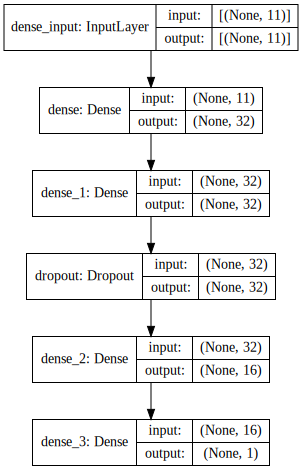

In [8]:
# モデルmodelを可視化
import tensorflow
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=None).create(prog='dot', format='svg'))

In [11]:
# 学習
from tensorflow.keras.callbacks import EarlyStopping

# patience 指定したepoch数改善がないと訓練を停止する.
# 10epoch改善がないと訓練を停止
early_stopping = EarlyStopping(patience=10, verbose=1)

# バッチサイズ : 32
# epoch : 20
# early_stopping : true
# 訓練セットのうち20%を検証用データとして用いる
# validation_split : 訓練データから検証用データとして設定されたデータは訓練時には使用されない
history = model.fit(x_train, y_train, batch_size=32, verbose=2, epochs=20,callbacks=[early_stopping],validation_split = 0.2)

Epoch 1/20
23/23 - 1s - loss: 1.1856 - accuracy: 0.4045 - val_loss: 0.7961 - val_accuracy: 0.5307
Epoch 2/20
23/23 - 0s - loss: 0.8027 - accuracy: 0.5309 - val_loss: 0.5905 - val_accuracy: 0.7263
Epoch 3/20
23/23 - 0s - loss: 0.6277 - accuracy: 0.6756 - val_loss: 0.5053 - val_accuracy: 0.7542
Epoch 4/20
23/23 - 0s - loss: 0.5718 - accuracy: 0.7233 - val_loss: 0.4590 - val_accuracy: 0.8156
Epoch 5/20
23/23 - 0s - loss: 0.5223 - accuracy: 0.7626 - val_loss: 0.4423 - val_accuracy: 0.8324
Epoch 6/20
23/23 - 0s - loss: 0.5180 - accuracy: 0.7556 - val_loss: 0.4272 - val_accuracy: 0.8380
Epoch 7/20
23/23 - 0s - loss: 0.5195 - accuracy: 0.7725 - val_loss: 0.4240 - val_accuracy: 0.8268
Epoch 8/20
23/23 - 0s - loss: 0.4992 - accuracy: 0.7725 - val_loss: 0.4153 - val_accuracy: 0.8324
Epoch 9/20
23/23 - 0s - loss: 0.5082 - accuracy: 0.7767 - val_loss: 0.4119 - val_accuracy: 0.8436
Epoch 10/20
23/23 - 0s - loss: 0.4845 - accuracy: 0.7893 - val_loss: 0.4068 - val_accuracy: 0.8436
Epoch 11/20
23/23 -

In [12]:
# モデルの評価
scores = model.evaluate(x_train, y_train, batch_size=32)

28/28 [==============================] - 0s 2ms/step - loss: 0.4080 - accuracy: 0.8429


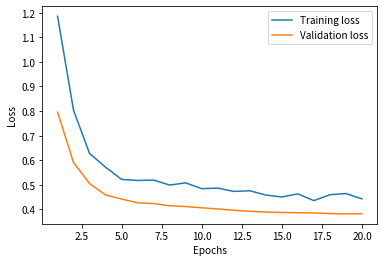

In [13]:
# ニューラルネットワークの分析
# 損失関数の履歴を取得
loss_train = history.history["loss"]
loss_val = history.history["val_loss"]

# 損失関数をプロット
epochs=range(1,21)
plt.figure(facecolor="white")
plt.plot(epochs,loss_train,label="Training loss")
plt.plot(epochs,loss_val,label="Validation loss")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

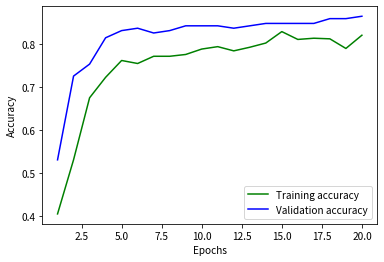

In [14]:
# 正解率を取得
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,21)
plt.figure(facecolor="white")
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [15]:
# create submission file
y_pred = model.predict(x_test)

y_final = (y_pred > 0.5).astype(int).reshape(x_test.shape[0])
submission = pd.DataFrame({'PassengerId': PassengerID, 'Survived': y_final})
submission.to_csv('Submission.csv', index=False)